In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
import random
import numpy as np
from PIL import Image
import copy
from joblib import Parallel,delayed

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
from skimage import data, img_as_float, exposure
from skimage.filters import unsharp_mask
import matplotlib.pyplot as plt

from IPython.display import display
import cv2
import os

In [41]:
def extract_images(folder_path):
  inputs = []
  ground_truths = []
  for filename in os.listdir(folder_path):
          if filename.lower().endswith((".jpg", ".png", ".jpeg")):
              image_path = os.path.join(folder_path, filename)
              if os.path.isfile(image_path):
                  img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                  img = cv2.resize(img, (256, 256))
                  if img is None:
                      continue
                  if "_gt" in filename.lower():
                      ground_truths.append(img)
                  else:
                      inputs.append(img)
  return inputs, ground_truths

In [42]:
#image tecnique implementation

def gamma_correction(image, gamma):
  if image is None:
    print("Image not found")
    return None
  org_imag_float = img_as_float(image)
  img_gamma = exposure.adjust_gamma(org_imag_float, gamma) # display(Image.fromarray((gamma_corrected * 255).astype(np.uint8)))
  return (img_gamma*255).astype(np.uint8)

def gaussian_blur(image, sigma):
  if image is None:
    print("Image not found")
    return None
  return cv2.GaussianBlur(image, (5,5), sigma)


def unsharp_masking(image, amount):
  if image is None:
    print("Image not found")
    return None
  org_img = img_as_float(image) #this is done unsharp_mask expects float type image
  img_unsharp = unsharp_mask(org_img, amount)
  return (img_unsharp * 255).astype(np.uint8)

def histogram_equalisation(image):
  if image is None:
    print("Image not found")
    return None
  return cv2.equalizeHist(image)


def contrast_stretching(image):
  if image is None:
    print("Image not found")
    return None
  min_val = np.min(image)
  max_val = np.max(image)

  if  max_val-min_val==0:
    return image.copy()

  con_image = ((image - min_val) / (max_val - min_val)) * 255

  return con_image.astype(np.uint8)


In [43]:
technique_dict = {
    "Gamma Correction": {"gamma": lambda: random.uniform(0.5, 2.0)},
    "Gaussian Blur": {"sigma": lambda: random.uniform(0.5, 5.0)},
    "Unsharp Masking": {"amount": lambda: random.uniform(0.5, 2.0)},
    "Histogram Equalisation": {},
    "Contrast Stretching": {},
}

In [44]:
from tabulate import tabulate
def ran_pipeline(min_len=4, max_len=5):
  len = random.randint(min_len, max_len)
  pipeline = []
  img_tech = list(technique_dict.keys()) #this will get and use the keys from the dictionary technique_dict
  for x in range(len):
    tech = random.choice(img_tech)
    params = {}
    for y,z in technique_dict[tech].items():
      params[y] = z()
    pipeline.append({"tech":tech, "params":params})
  return pipeline

In [45]:
def image_to_pipeline(pipeline, image):
  if image is None:
    print("Image not found in pipeline processing")
    return None
  img_enhanced = image.copy()

  for step in pipeline:
    tech = step["tech"]
    if tech == "Gamma Correction":
      img_enhanced = gamma_correction(img_enhanced, step["params"]["gamma"])
    elif tech == "Gaussian Blur":
      img_enhanced = gaussian_blur(img_enhanced, step["params"]["sigma"])
    elif tech == "Unsharp Masking":
      img_enhanced = unsharp_masking(img_enhanced, step["params"]["amount"])
    elif tech == "Histogram Equalisation":
      img_enhanced = histogram_equalisation(img_enhanced)
    elif tech == "Contrast Stretching":
      img_enhanced = contrast_stretching(img_enhanced)
  return np.clip(img_enhanced,0,255).astype(np.uint8)

In [46]:
#fitness Function
def fitness_function(population,train_input,test_input):
  fit_scores = []
  def apply_pipeline(pipeline):
    pipeline_final_score = 0.0
    processed_images_count = 0

    for x in range(min(len(test_input), len(train_input))):
      output_image = test_input[x]
      input_image = train_input[x]

      if input_image is not None and output_image is not None:
        image_enhance = image_to_pipeline(pipeline, input_image)
        if image_enhance is not None:
          p_score = psnr(output_image, image_enhance,data_range=255)
          s_score = ssim(output_image, image_enhance,data_range=255)
          m_score = mse(output_image, image_enhance)
          current_score = p_score + s_score + m_score * 0.001
          pipeline_final_score += current_score
          processed_images_count += 1
      return pipeline_final_score / processed_images_count if processed_images_count > 0 else 0

  fit_scores = Parallel(n_jobs=-1)(delayed(apply_pipeline)(pipeline) for pipeline in population)
  return fit_scores

In [47]:
#Population Random
def random_population(pop_size):
  population = []
  for x in range(pop_size):
    population.append(ran_pipeline())
  return population



In [48]:
#selection --> tournment selction will be used
def select_parents(population,fitnesses, k):
  selected_individuals = []
  for _ in range(2): # Select 2 parents
    tournament_participants_indices = random.sample(range(len(population)), k)
    best_participant_index = -1
    best_fitness = -1

    for index in tournament_participants_indices:
      if fitnesses[index] > best_fitness:
        best_fitness = fitnesses[index]
        best_participant_index = index
    selected_individuals.append(population[best_participant_index])
  return selected_individuals

In [49]:
#crossover
def crossover(parent1, parent2):
  if len(parent1) < 2 or len(parent2) < 2:
    # Handle cases with short parents - simply return a deep copy of one
    return copy.deepcopy(random.choice([parent1, parent2]))

  section_1 = random.randint(0, len(parent1) - 1)
  section_2 = random.randint(0, len(parent2) - 1)

  # Create a new offspring by combining parts of the parents
  new_offspring = parent1[:section_1] + parent2[section_2:] # Use section_2 for parent2

  return new_offspring

In [50]:
#mutation
def mutation(offspring, mutate_rate=0.3):
  new_spring = copy.deepcopy(offspring)
  if random.random() < mutate_rate and new_spring:
    index = random.randrange(len(new_spring))
    new_tech_name = new_spring[index]["tech"] # Get the name of the current technique

    if random.random() < mutate_rate: # Mutate the technique itself
      new_tech_name = random.choice(list(technique_dict.keys()))

    # Generate new parameters for the (potentially new) technique
    new_params = {}
    if new_tech_name in technique_dict:
        for param_name, param_func in technique_dict[new_tech_name].items():
            new_params[param_name] = param_func()

    new_spring[index] = {"tech": new_tech_name, "params": new_params}

  return new_spring

In [51]:
#GA LOOP
def genetic_algorithm(train_input,test_input,pop_size, gens, cross_rate, mutate_rate):
  population = random_population(pop_size)
  pop_fit = fitness_function(population, train_input,test_input)
  best_pipeline = None
  best_fitness = -1
  gen_wo_improve = 0

  if not pop_fit:  # Check if fitness scores are empty
      print("Cannot run GA with empty fitness scores. Check if images were loaded correctly.")
      return None, None

  for x in range(gens):
    new_population = [] # Initialize offspring list in each generation

    while len(new_population) < pop_size:
      parent_1, parent_2 = select_parents(population, pop_fit, 3)

      if random.random() < cross_rate:
        offspring = crossover(parent_1, parent_2)
      else:
        offspring = copy.deepcopy(parent_1)

      new_child = copy.deepcopy(offspring) # Initialize new_child

      if random.random() < mutate_rate:
        new_child = mutation(offspring, mutate_rate)

      new_population.append(new_child)

    population = new_population
    pop_fit = fitness_function(population, train_input,test_input)

    gen_best_index = pop_fit.index(max(pop_fit))
    best_gen_pipeline = population[gen_best_index]
    best_gen_score = pop_fit[gen_best_index]

    if best_gen_score > best_fitness:
      best_fitness = best_gen_score
      best_pipeline = best_gen_pipeline
      gen_wo_improve = 0
    else:
      gen_wo_improve += 1

    if gen_wo_improve > 10: #10 here is the patience limit
      print(f"Convergence reached after {x+1} generations. Stopping GA.")
      break

    print(f"Generation {x+1}: Best Fitness = {best_fitness}")

  return best_pipeline, best_fitness

In [52]:
#VNS

def vns_shake(pipeline, k):
  new_pipeline = copy.deepcopy(pipeline)
  if not new_pipeline:
    return ran_pipeline() # Return a new random pipeline

  if k % 3 == 0: # This will change the technique of a step
    index = random.randrange(len(new_pipeline))
    new_tech_name = random.choice(list(technique_dict.keys()))
    # Generate new parameters for the new technique
    new_params = {}
    if new_tech_name in technique_dict:
        for param_name, param_func in technique_dict[new_tech_name].items():
            new_params[param_name] = param_func()
    new_pipeline[index] = {"tech": new_tech_name, "params": new_params}

  elif k % 3 == 1: # This will change parameters of a step
    if new_pipeline: # Ensure the pipeline is not empty
        index = random.randrange(len(new_pipeline))
        tech_name = new_pipeline[index]["tech"]
        new_params = {}
        if tech_name in technique_dict:
            for param_name, param_func in technique_dict[tech_name].items():
                new_params[param_name] = param_func()
        new_pipeline[index]["params"] = new_params

  else: # Add or remove a step
    if random.random() < 0.5 and len(new_pipeline) > 1:
      del new_pipeline[random.randrange(len(new_pipeline))]
    else:
      new_tech_name = random.choice(list(technique_dict.keys()))
      new_params = {}
      if new_tech_name in technique_dict:
          for param_name, param_func in technique_dict[new_tech_name].items():
              new_params[param_name] = param_func()
      new_pipeline.append({"tech": new_tech_name, "params": new_params})

  return new_pipeline

In [53]:
def vns_local_search(pipeline, train_input, test_input, iteration_limit):
  best_line = copy.deepcopy(pipeline)
  best_fit = fitness_function([best_line],train_input,test_input)[0]

  for x in range(iteration_limit):
    neighbour = mutation(best_line)
    neighbour_score = fitness_function([neighbour],train_input,test_input)[0]
    if neighbour_score > best_fit:
      best_line, best_fit = neighbour, neighbour_score

  return best_line, best_fit

In [54]:
def variable_neighbourhood_search(train_input,test_input,epochs_limit, k_max):
  now_pipeline = ran_pipeline()
  now_fit = fitness_function([now_pipeline],train_input,test_input)[0]
  best_pipeline = now_pipeline
  best_fit = now_fit


  for epoch in range(epochs_limit):
    k = 0
    while k < k_max:
      shaken_pipeline = vns_shake(now_pipeline, k)
      improved_pipeline, improved_fit = vns_local_search(shaken_pipeline, train_input,test_input, 5)

      if improved_fit > now_fit: # Check against the current pipeline's fitness
        now_pipeline, now_fit = improved_pipeline, improved_fit
        if improved_fit > best_fit: # Check against the overall best fitness
          best_pipeline, best_fit = improved_pipeline, improved_fit
          k = 0 # Reset k if improvement is found in the local search
      else:
        k += 1

      print(f"Epoch {epoch+1}, k={k}: Best Fitness = {best_fit}") # Added k to print for better tracking

    if k >= 5: # Check for convergence
        print(f"Convergence reached after {epoch+1} epochs. Stopping VNS.")
        break # Exit the epoch loop if convergence is reached
    k += 1 # Increment counter if no improvement in the epoch
  return best_pipeline, best_fit


In [55]:
def test_pipelines(pipeline, test_input, test_ground):
  scores = {"psnr":[], "ssim":[], "mse":[]}
  for x in range(min(len(test_input), len(test_ground))):
    output_image = test_ground[x]
    input_image = test_input[x]
    if output_image is not None and input_image is not None:
      image_enhance = image_to_pipeline(pipeline, input_image)
      if image_enhance is not None:
        p_score = psnr(output_image, image_enhance,data_range=255)
        s_score = ssim(output_image, image_enhance,data_range=255)
        m_score = mse(output_image, image_enhance)
        scores["psnr"].append(p_score)
        scores["ssim"].append(s_score)
        scores["mse"].append(m_score)
  return scores

In [56]:
def show_images(ga_pipeline, vns_pipeline, test_input, test_ground):
  indexes = random.sample(range(len(test_input)),min(3,len(test_input)))
  for x in indexes:
    output_image = test_ground[x]
    input_image = test_input[x]
    ga_pipeline_image = image_to_pipeline(ga_pipeline, input_image)
    vns_pipeline_image = image_to_pipeline(vns_pipeline, input_image)

    plt.figure(figsize=(15, 5))

     # Input
    plt.subplot(1, 4, 1)
    plt.imshow(input_image, cmap="gray")
    plt.title("Input")
    plt.axis("off")

        # Ground truth
    plt.subplot(1, 4, 2)
    plt.imshow(output_image, cmap="gray")
    plt.title("Ground Truth")
    plt.axis("off")

    # GA Enhanced
    plt.subplot(1, 4, 3)
    if ga_pipeline_image is not None:
       plt.imshow(ga_pipeline_image, cmap="gray")
       plt.title("GA Enhanced")
       plt.axis("off")

        # VNS Enhanced
    plt.subplot(1, 4, 4)
    if vns_pipeline_image is not None:
       plt.imshow(vns_pipeline_image, cmap="gray")
       plt.title("VNS Enhanced")
       plt.axis("off")
    plt.show()

Beginning with GA optimization
Generation 1: Best Fitness = 19.075784626625374
Generation 2: Best Fitness = 20.146680114349437
Generation 3: Best Fitness = 20.146680114349437
Generation 4: Best Fitness = 20.537797359081452
Generation 5: Best Fitness = 20.616058868059795
Generation 6: Best Fitness = 20.640093295048317
Generation 7: Best Fitness = 20.64020541183624
Generation 8: Best Fitness = 20.64020541183624
Generation 9: Best Fitness = 20.64020541183624
Generation 10: Best Fitness = 20.64020541183624
Generation 11: Best Fitness = 20.64020541183624
Generation 12: Best Fitness = 20.64020541183624
Generation 13: Best Fitness = 20.64020541183624
Generation 14: Best Fitness = 20.64020541183624
Generation 15: Best Fitness = 20.64020541183624
Generation 16: Best Fitness = 20.64020541183624
Generation 17: Best Fitness = 20.64020541183624
Convergence reached after 18 generations. Stopping GA.
Best GA pipeline found: [{'tech': 'Gamma Correction', 'params': {'gamma': 1.9770396386451012}}, {'tec

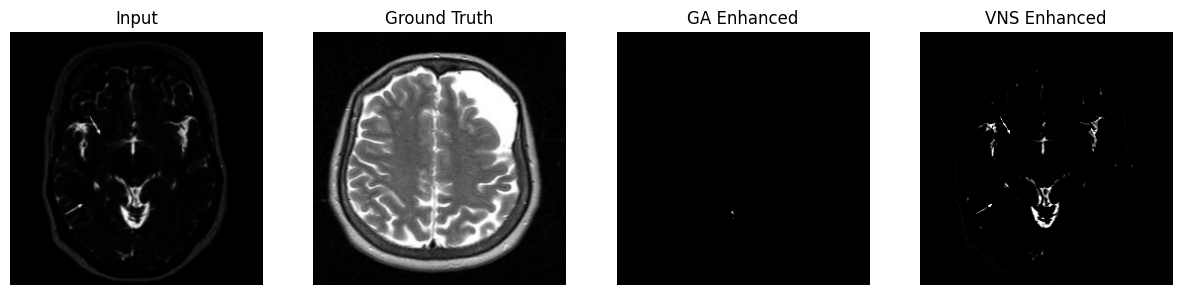

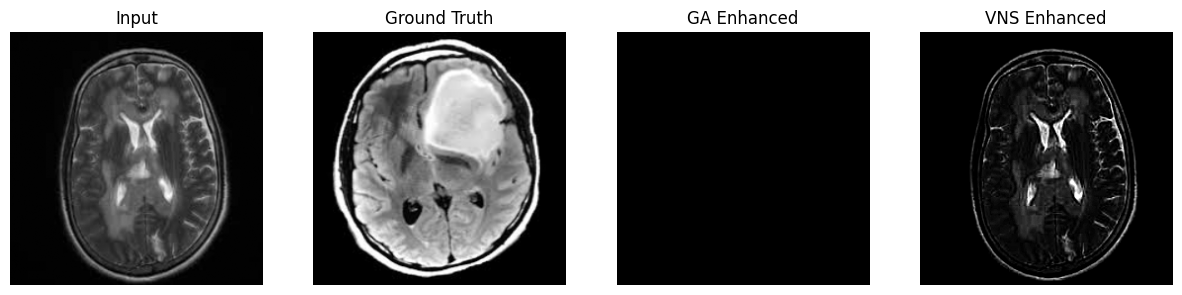

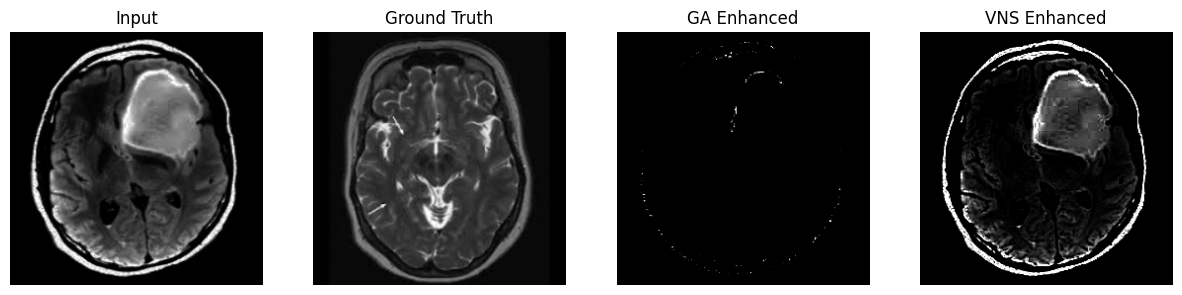


=== Program Complete ==


In [57]:
#main
if __name__ == "__main__":

  test_inputs_pics,tests_ground_pics = extract_images("/content/drive/MyDrive/COS791-ASSIGNMENT-ONE-DATA/Test_data/Test_data")
  train_inputs_pics,train_ground_pics = extract_images("/content/drive/MyDrive/COS791-ASSIGNMENT-ONE-DATA/Training_data/train_data")

  if not train_inputs_pics or not test_inputs_pics:
      print("Error: Could not load training or test images. Please check the folder paths and image formats.")
  else:
       print("Beginning with GA optimization")
       pop_size = 30
       gens = 35
       cross_rate = 0.8 #0.8 was selected for recombination
       mutate_rate = 0.2 #for more diversity
       best_ga_pipeline, best_ga_fitness = genetic_algorithm(train_inputs_pics,train_ground_pics,pop_size,gens,cross_rate,mutate_rate)

       if best_ga_pipeline is not None:
            print(f"Best GA pipeline found: {best_ga_pipeline}")
            print(f"Best GA fitness score: {best_ga_fitness}")
       else:
            print("GA optimization could not be completed due to issues.")


       print("Beginning with VNS optimization")
       epochs_limit = 30
       k_max = 10
       best_vns_pipeline, best_vns_fitness = variable_neighbourhood_search(train_inputs_pics,train_ground_pics,epochs_limit,k_max)
       if best_vns_pipeline is not None:
            print(f"Best VNS pipeline found: {best_vns_pipeline}")
            print(f"Best VNS fitness score: {best_vns_fitness}")
       else:
          print("VNS optimization could not be completed due to issues.")

print("\n=== Now, evaluating GA pipeline on test images ==")
ga_test = test_pipelines(best_ga_pipeline, test_inputs_pics, tests_ground_pics)
print("GA Test Results:", ga_test)
print("\n=== Now, evaluating VNS pipeline on test images ==")
vns_test = test_pipelines(best_vns_pipeline, test_inputs_pics, tests_ground_pics)
print("\nVNS Test Results:", vns_test)

print("\nShowing Test Results using Images Chosen At Random")
show_images(best_ga_pipeline,best_vns_pipeline,test_inputs_pics,tests_ground_pics)
print("\n=== Program Complete ==")